Практическая работа № 3

Выполнил студент группы ББМО-01-23: Панков.Н.О

In [ ]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')
# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Точность теста на чистых изображениях: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9715 - loss: 0.0998
Точность теста на чистых изображениях: 0.9754999876022339


In [ ]:
# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))
# Выбор изображения для атаки (например, первое изображение из тестового набора)
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]  # Добавляем размерность для батча
label = np.argmax(test_labels[0])  # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор
# Выполнение атаки
attack = fb.attacks.L2CarliniWagnerAttack(steps=3)
print(label)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)  # Оборачиваем метку в тензор с размерностью (1,)

tf.Tensor(7, shape=(), dtype=int64)


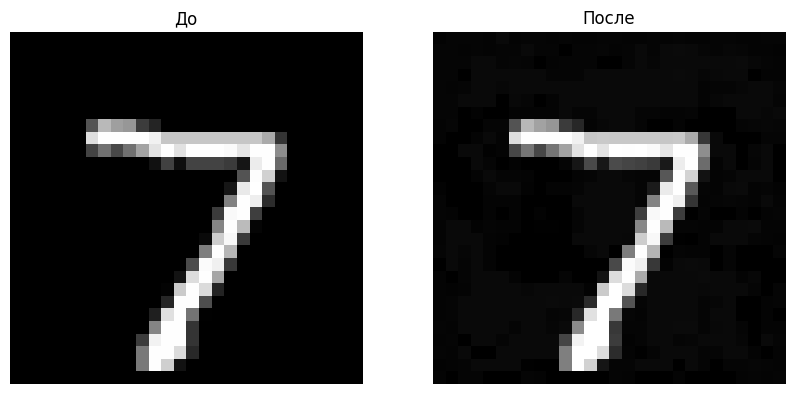

In [ ]:
# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("До")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("После")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')
plt.show()

In [ ]:
adversarial_images = []
# Обработка изображений
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]  # Форма (1, height, width, channels)
    label = np.argmax(test_labels[i])  # Получаем индекс класса
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)
adversarial_images = tf.concat(adversarial_images, axis=0)  # Объединение по нулевой оси
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Точность на состязательных примерах (атака CW): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0742 - loss: 2.2621
Accuracy on adversarial examples (CW attack): 0.07490000128746033


Вывод

Точность модели на атакованных примерах значительно снизилась, что указывает на её неспособность корректно распознавать изображения при наличии целенаправленных, минимальных искажений. Это подчеркивает необходимость разработки более устойчивых моделей и использования методов защиты от атак для повышения надежности в практических приложениях.